In [21]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

#others
from xgboost import XGBRegressor
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import time
import xarray as xr
import sherpa
import time
from scipy.spatial import Delaunay
from scipy import interpolate
from copy import deepcopy

# enable autoreload
%load_ext autoreload
%autoreload 2
# Variables from config file
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS


# Train site-specific Linear Regression and compare the results with single-model XGBoost.

Input lables to use: Single observation from the closest observation, with lat, lon, seasonality, and elevation

In [154]:
columns = deepcopy(LABELS)
columns.extend(["data_in", "season_wet", "elevation", "lat", "lon"])
for item in columns:
    print(item, end=' ')

# load datasets
df_train = pd.read_csv(f"{BASE_DIR}/train.csv", usecols=columns + ['year', 'month', 'skn'])
df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv", usecols=columns + ['year', 'month', 'skn'])
df_test = pd.read_csv(f"{BASE_DIR}/test.csv", usecols=columns + ['year', 'month', 'skn'])
df_combined = pd.concat([df_train, df_valid, df_test])

air2m air1000_500 hgt500 hgt1000 omega500 pottemp1000-500 pottemp1000-850 pr_wtr shum-uwnd-700 shum-uwnd-925 shum-vwnd-700 shum-vwnd-950 shum700 shum925 skt slp data_in season_wet elevation lat lon 

### Assign chrono-split index to each data: `n_folds = 5`

In [155]:
n_folds = 5

df_len_by_month = pd.DataFrame(df_combined.groupby(by=["year", "month"]).size()).reset_index().rename({0:"len"}, axis=1)
df_len_by_month['cumsum'] = df_len_by_month['len'].cumsum()

n_samples_total = df_len_by_month['cumsum'].iloc[-1]
n_samples_per_fold = np.ceil(n_samples_total / n_folds)

df_len_by_month['fold'] = df_len_by_month.apply(lambda row: int(row['cumsum'] / n_samples_per_fold), axis=1)

for fold in range(5):
    print(df_len_by_month[df_len_by_month['fold'] == fold]['len'].sum())

172693
172475
173153
174015
173225


In [165]:
df_combined = pd.merge(left=df_combined, right=df_len_by_month, left_on=["year", "month"], right_on=["year", "month"])

## 1. No chrono-split

In [162]:
num_groups = df_combined['skn'].unique().shape[0]
df_result = []
for i, (skn, group) in enumerate(df_combined.groupby("skn")):# iterate the group object
    if group.shape[0] < 5: continue
    # Randomize the order: this causes high variance in performance
    group = group.sample(frac=1)
    group = group[columns]
    
    Y = np.array(group["data_in"])
    X = np.array(group.drop(["data_in"], axis=1))
    
    y_pred = cross_val_predict(LinearRegression(), X, Y, cv=5, n_jobs=-1)
    
    group["prediction_multi_linear"] = y_pred
    df_result.append(group)
    
    # print out the progress
    print(f"{i}/{num_groups}", end="\r")
print()

df_result = pd.concat(df_result)

rmse_multi_linear = mean_squared_error(df_result['data_in'], df_result['prediction_multi_linear'], squared=False)
print("RMSE with site-specific linear regression: {:.3f}".format(rmse_multi_linear))

1991/1992


In [50]:
# xgb
xgboost = XGBRegressor(
    n_estimators=280,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

Xtrain = np.array(df_train[columns].drop(["data_in"], axis=1))
Ytrain = np.array(df_train["data_in"])

Xtest = np.array(df_test[columns].drop(["data_in"], axis=1))
Ytest = np.array(df_test["data_in"])

xgboost.fit(Xtrain, Ytrain)
yhat = xgboost.predict(Xtest)
rmse_single_xgb = mean_squared_error(Ytest, yhat, squared=False)
print("RMSE with single xgboost regression: {:.3f}".format(rmse_single_xgb))

RMSE with single xgboost regression: 4.018


## 1.1 Apply chrono split

In [195]:
num_groups = df_combined['skn'].unique().shape[0]
df_result = []
for i, (skn, group) in enumerate(df_combined.groupby("skn")):# iterate the group object
    if group.shape[0] < 5: continue
    # sort chronologically
    # enforce chrono split
    group.sort_values(by=["year", "month"], inplace=True)
    
    Y = np.array(group[columns]["data_in"])
    X = np.array(group[columns].drop(["data_in"], axis=1))
    
    y_pred = cross_val_predict(LinearRegression(), X, Y, cv=5, n_jobs=-1)
    
    group["prediction_multi_linear"] = y_pred
    df_result.append(group)
    
    # print out the progress
    print(f"{i}/{num_groups}", end="\r")
print()

df_result_linear = pd.concat(df_result)

rmse_multi_linear = mean_squared_error(df_result_linear['data_in'], df_result_linear['prediction_multi_linear'], squared=False)
print("RMSE with site-specific linear regression: {:.3f}".format(rmse_multi_linear))

1991/1992
RMSE with site-specific linear regression: 4.098


In [196]:
xgboost = XGBRegressor(
    n_estimators=280,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

start = time.time()
df_result = []
for fold in range(n_folds):
    print(f"Running the {fold}-th fold")
    df_train = df_combined[df_combined['fold'] != fold]
    df_test = df_combined[df_combined['fold'] == fold]
    
    Xtrain = np.array(df_train[columns].drop("data_in", axis=1))
    Ytrain = np.array(df_train["data_in"])
    
    Xtest = np.array(df_test[columns].drop("data_in", axis=1))
    Ytest = np.array(df_test["data_in"])
    
    xgboost.fit(Xtrain, Ytrain)
    
    yhat = xgboost.predict(Xtest)
    df_test['prediction_single_xgb'] = yhat
    df_result.append(df_test)
    
end = time.time()

df_result_xgb = pd.concat(df_result)

print(end - start)

Running the 0-th fold
Running the 1-th fold
Running the 2-th fold
Running the 3-th fold
Running the 4-th fold
274.9581937789917


In [198]:
mean_squared_error(df_result_xgb['data_in'], df_result_xgb['prediction_single_xgb'], squared=False)

3.998269428278984

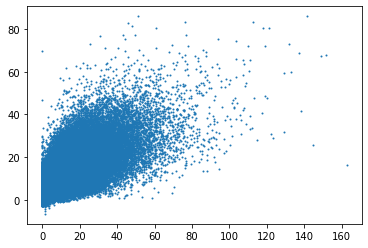

In [185]:
fig, ax = plt.subplots(1)
ax.scatter(x=df_result['data_in'], y=df_result["predict_sigle_xgb"], s=1)

In [ ]:
df_result_linear['prediction_single_xgb'] = df_result_xgb['preduction_single_xgb']
df_result_linear

### justification on the difference from the past experiments
1. Basemodel_Comparison.ipynb: data split was inappropriate


In [ ]:
# use (Sin, cos) for month